# MMI splitter

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil

import meep as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Define the system
# parameters for 1220nm
sm_width = .35  # um
wavelength = 1.22  # um
frequency = 1 / 1.22
MMI_width = 2
MMI_length = 6.3
out_pitch = MMI_width / 1.78

cell = mp.Vector3(24, 8, 0)

background = mp.Block(mp.Vector3(cell.x, cell.y, 1e20),
                     center=mp.Vector3(0, 0),
                     material=mp.Medium(epsilon=3.9))
geometry = [background,
            mp.Block(mp.Vector3(cell.x / 2, sm_width, 1e20),
                     center=mp.Vector3(-cell.x / 4, 0),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(MMI_length, MMI_width, 1e20),
                     center=mp.Vector3(MMI_length / 2, 0),
                     material=mp.Medium(epsilon=12)),
            
           ]
reflector = True
if reflector:
    geometry.append(mp.Prism([mp.Vector3(MMI_length, MMI_width / 2),
                              mp.Vector3(MMI_length, -MMI_width / 2),
                              mp.Vector3(MMI_length + MMI_width, 0),
                             ], 
                    height=0, material=mp.Medium(epsilon=12)))
else:
    geometry.extend([
            mp.Block(mp.Vector3(cell.x / 2, sm_width, 1e20),
                     center=mp.Vector3(cell.x / 4, out_pitch / 2),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(cell.x / 2, sm_width, 1e20),
                     center=mp.Vector3(cell.x / 4, -out_pitch / 2),
                     material=mp.Medium(epsilon=12)),
                    ])
# this should be replaced by an eigenmode
# sources = [mp.Source(mp.ContinuousSource(frequency=frequency, width=2),
#                      component=mp.Ez,
#                      center=mp.Vector3(-cell.x / 2 + 1, 0),
#                      size=mp.Vector3(0, sm_width))]
df = frequency / 2
sources = [mp.Source(mp.GaussianSource(frequency, fwidth=df), 
                     component=mp.Ez,
                     center=mp.Vector3(-cell.x / 2 + 1, 0), 
                     size=mp.Vector3(0, sm_width))]

pml_layers = [mp.PML(1.0)]

resolution = 20

-----------
Initializing structure...
run 0 finished at t = 1.0 (40 timesteps)


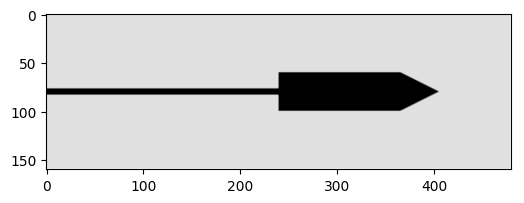

In [12]:
# Do the simulation, and verify the geometry
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    symmetries=[mp.Mirror(mp.Y)])
def verify_geometry():
    sim.run(until=1)
    eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
    plt.figure(dpi=100)
    plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
verify_geometry()

-----------
Initializing structure...
Meep: using output directory 'outputs'
Meep progress: 103.0/300.0 = 34.3% done in 4.0s, 7.7s to go
Meep progress: 197.0/300.0 = 65.7% done in 8.0s, 4.2s to go
Meep progress: 235.0/300.0 = 78.3% done in 14.1s, 3.9s to go
run 1 finished at t = 300.0 (12000 timesteps)


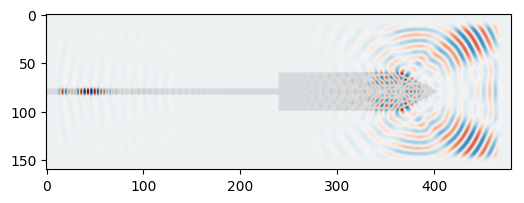

In [13]:
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
#             mp.at_beginning(mp.output_epsilon),
            mp.at_every(1, mp.output_png(mp.Ez, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
    ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
    plt.figure(dpi=100)
    plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
#     plt.axis('off')
    # now make the gif
    subprocess.check_call(['convert', 'outputs/ez-*.png', 'ez.gif'])
    subprocess.check_call(['open', '-a', 'Safari', 'ez.gif'])
plot_sim(300)